# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mylib.fonction_exploration import exploration1, exploration2, exploration3, exploration4
from mylib.fonction_pk import test_pk
from mylib.fonction_merge import df_merge
from mylib.fonction_acp import display_circles, display_factorial_planes, display_scree_plot
import mylib.fonction_clustering as fonction_clustering
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import seaborn as sns
from pandas_profiling import ProfileReport
import plotly.express as px
from IPython.display import display_html 

from sklearn.cluster import KMeans
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
#from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

print("Version numpy : " + np.__version__)
print("Version pandas : " + pd.__version__)

bold = "\033[1m"
red = "\033[31m"
end = "\033[0;0m"

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "111%"),
                              ("color", 'black')])]

chemin1 = '../src/p9_2010_cleaned.xlsx'
chemin2 = '../src/p9_log_2010_cleaned.xlsx'

Version numpy : 1.23.5
Version pandas : 1.4.4


# Loading the cleaned files

In [2]:
p9 = pd.read_excel(chemin1)
p9_log = pd.read_excel(chemin2)
p9_log = p9_log.set_index('Country')

<span style="color:red">**==> En vue de la future visualisation du diagramme de Sankey, on exportera à la fin le DataFrame crée et on réitèrera le processus avec détermination des clusters pour chaque année entre 2010 et 2020
<br>==> Pour une meilleure cohérence visuelle on imposera le même nombre de clusters optimal pour chaque année, à savoir 4**</span>

# Principal Component Analysis

In [3]:
# import de l'échantillon et des informations
data = p9_log

# préparation des données pour l'ACP
X = data.values
names = data.index

# centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# ACP
pca = decomposition.PCA(n_components=4).fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [4]:
pd.DataFrame({"Dimension" : [f"Dim{i+1}" for i in range(4)],
              "Variance (%)" : np.round(pca.explained_variance_ratio_ * 100, 2),
             "Cumulative variance (%)" : np.round(pca.explained_variance_ratio_.cumsum() * 100, 2)})

Dimension  Variance (%)  Cumulative variance (%)
0      Dim1         33.78                    33.78
1      Dim2         20.68                    54.46
2      Dim3         11.81                    66.27
3      Dim4          7.76                    74.03

In [5]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = data.columns
pcs.index = [f"F{i}" for i in range(1, 5)]
pcs = pcs.round(2).T
pcs

F1    F2    F3    F4
Population                              -0.03 -0.45  0.35 -0.04
Under-nourishment (%)                    0.38 -0.01 -0.02  0.04
HDI                                     -0.39  0.11  0.12 -0.05
Peace_index                              0.24 -0.19  0.14 -0.01
Vegetables disponibility (kg/cap/year)  -0.07 -0.28 -0.40 -0.46
Enough veg intake (> 91.25 kg/cap/year) -0.14 -0.18 -0.43 -0.38
Production                              -0.08 -0.52  0.10 -0.05
Exportations                            -0.23 -0.28  0.19  0.20
Importations                            -0.26 -0.14  0.46 -0.24
Customs duration (h)                     0.33 -0.07  0.10 -0.22
Customs tax (%)                          0.32 -0.15  0.08 -0.11
Distance (km)                            0.27 -0.07  0.16  0.04
Gdp/cap                                 -0.36  0.14  0.20 -0.10
Population evolution (4y, %)             0.26 -0.03  0.22 -0.13
Trade balance (exp-imp)                 -0.04 -0.25 -0.19  0.64
Self-sufficiency (prod-dispo)           -0.06 -0.40 -0.28  0.20
Market growth (2y, %)                   -0.00  0.00  0.00  0.00

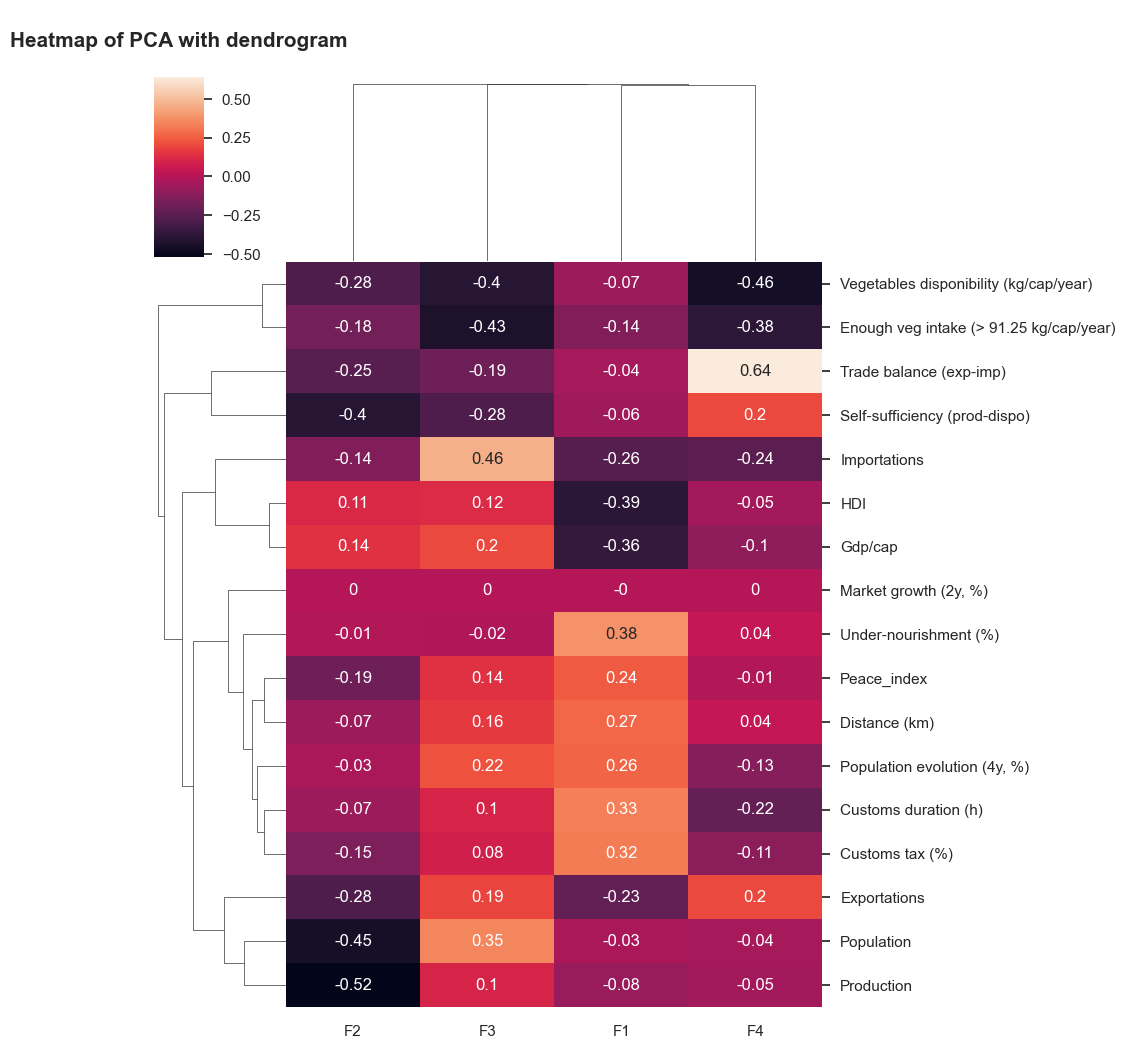

In [6]:
#fig = plt.figure(figsize=(15,12))
sns.set(font_scale=1)
sns.clustermap(pcs, annot=True)
plt.title('\nHeatmap of PCA with dendrogram\n', fontsize=15, fontweight='bold');

# **HCA**

## Dendrogram visualization

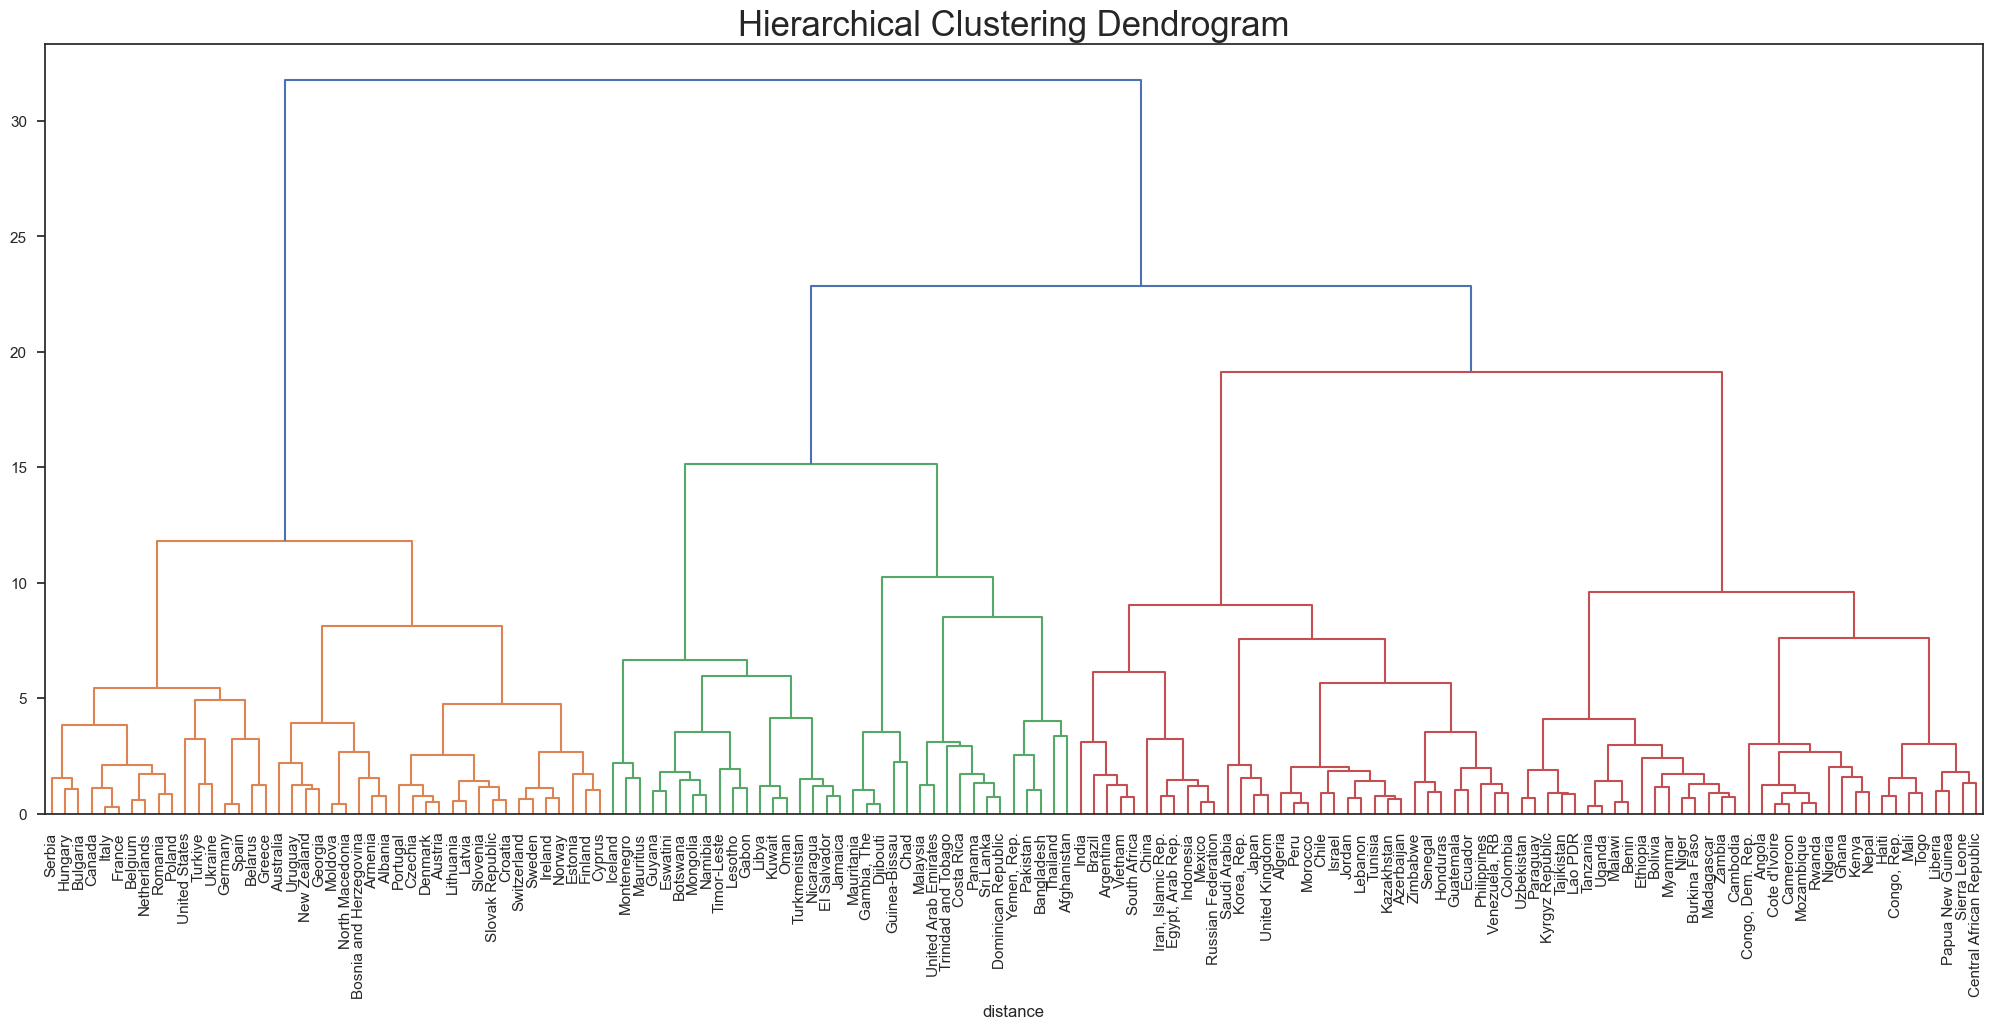

In [7]:
# clustering hiérarchique
Z = linkage(X_projected, 'ward') # ward method, euclidean metric

# affichage du dendrogramme
#%pylab inline
sns.set_style('ticks')
plt.figure(figsize=(25,10))
plt.title('Hierarchical Clustering Dendrogram',size=25)
plt.xlabel('distance')
dendrogram(Z,labels = names,leaf_font_size=11,orientation = "top")
#plt.axhline(y=15, color='r', linestyle='--')
plt.show()

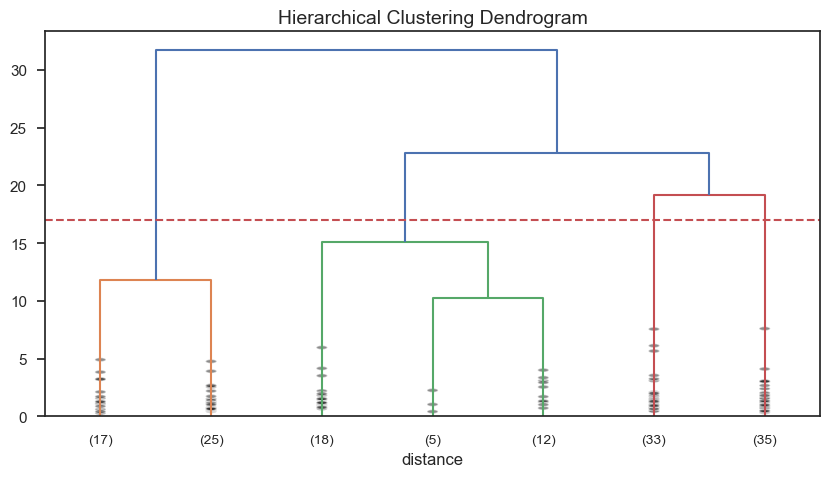

In [8]:
#%pylab inline
plt.figure(figsize=(10,5))
plt.title('Hierarchical Clustering Dendrogram',size=14)
plt.xlabel('distance')
dendrogram(Z,labels = names,p=7, truncate_mode='lastp',leaf_font_size=10,orientation = "top",show_contracted=True)
plt.axhline(17, color='r', linestyle='--')
plt.show()

## Saving the file

In [9]:
labels = fcluster(Z, 17, criterion='distance')
clusters_cah_pca = pd.DataFrame({'clusters': labels, 'Country': data.index})
#clusters_cah_pca.head()
clusters_cah_pca['Cluster name'] = clusters_cah_pca['clusters'].map({1: '2010 Richest countries, sufficient dispo in vegetables',
                                                         2: '2010 Poor and mid-developped countries, lack of vegetables',
                                                         3: '2010 Biggest productors, exportators and importators, sufficient dispo in vegetables',
                                                         4: '2010 Poorest under-developped countries, biggest dispo in vegetables'
                                                         })
# en vue de la future visualisation du diagramme de Sankey, on enregistre le fichier et on réitère le processus avec détermination des clusters pour chaque année
# on utlise les 3 visualisation ci-dessous (boxplots, heatmap, radar chart) pour spécifier les groupes 
clusters_cah_pca.to_excel('../src/sankey_2010.xlsx', index=True)
print("Exportation terminée")
#clusters_cah_pca.head()

Exportation terminée


In [10]:
c1_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 1].drop(columns=('clusters'))
c2_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 2].drop(columns=('clusters'))
c3_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 3].drop(columns=('clusters'))
c4_cah_acp = clusters_cah_pca[clusters_cah_pca["clusters"] == 4].drop(columns=('clusters'))

df1_styler = c1_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 1 CAH').set_table_styles(styles)
df2_styler = c2_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 2 CAH').set_table_styles(styles)
df3_styler = c3_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 3 CAH').set_table_styles(styles)
df4_styler = c4_cah_acp.style.set_table_attributes("style='display:inline'").set_caption('Cluster 4 CAH').set_table_styles(styles)

space = "\xa0" * 10
display_html(df1_styler._repr_html_() + space + df2_styler._repr_html_() + space + df3_styler._repr_html_() \
             + space + df4_styler._repr_html_(), raw=True)

Cluster 1 CAH 
 
 
   
 Country 
 Cluster name 
 
 
 
 
 4 
 Australia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 9 
 Uruguay 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 13 
 Slovak Republic 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 15 
 Denmark 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 19 
 Germany 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 26 
 Lithuania 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 29 
 Portugal 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 30 
 Latvia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 32 
 Armenia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 33 
 Slovenia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 35 
 Bosnia and Herzegovina 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 36 
 Turkiye 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 38 
 Belgium 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 41 
 Croatia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 42 
 Romania 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 44 
 Moldova 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 45 
 Netherlands 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 46 
 Ukraine 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 48 
 Hungary 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 49 
 Belarus 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 51 
 Canada 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 55 
 Poland 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 56 
 Spain 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 57 
 Albania 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 59 
 New Zealand 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 60 
 Italy 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 61 
 Austria 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 63 
 Bulgaria 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 65 
 Greece 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 66 
 France 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 67 
 North Macedonia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 71 
 United States 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 80 
 Switzerland 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 88 
 Sweden 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 90 
 Estonia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 100 
 Ireland 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 105 
 Norway 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 116 
 Finland 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 119 
 Cyprus 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 133 
 Czechia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 141 
 Georgia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 144 
 Serbia 
 2010 Richest countries, sufficient dispo in vegetables 
 
 
 
          
 
 Cluster 2 CAH 
 
 
   
 Country 
 Cluster name 
 
 
 
 
 0 
 Lesotho 
 2010 Poor and mid-developped countries, lack of vegetables 
 
 
 3 
 Gabon 
 2010 Poor and mid-developped countries, lack of vegetables 
 
 
 23 
 Costa Rica 
 2010 Poor and mid-developped countries, lack of vegetables 
 
 
 43 
 Thailand 
 2010 Poor and mid-developped countries, lack of vegetables 
 
 
 74 
 Mauritania 
 2010 Poor and mid-developped countries, lack of vegetables 
 
 
 75 
 Montenegro 
 2010 Poor and mid-developped countries, lack of vegetables 
 
 
 76 
 Sri Lanka 
 2010 Poor and mid-developped countries, lack of vegetables 
 
 
 77 
 Mongolia 
 2010 Poor and mid-developped countries, lack of

## HCA boxplots

In [11]:
p9_cah_pca = p9_log.merge(clusters_cah_pca, on="Country", how="inner")
#p9_cah_pca.head()

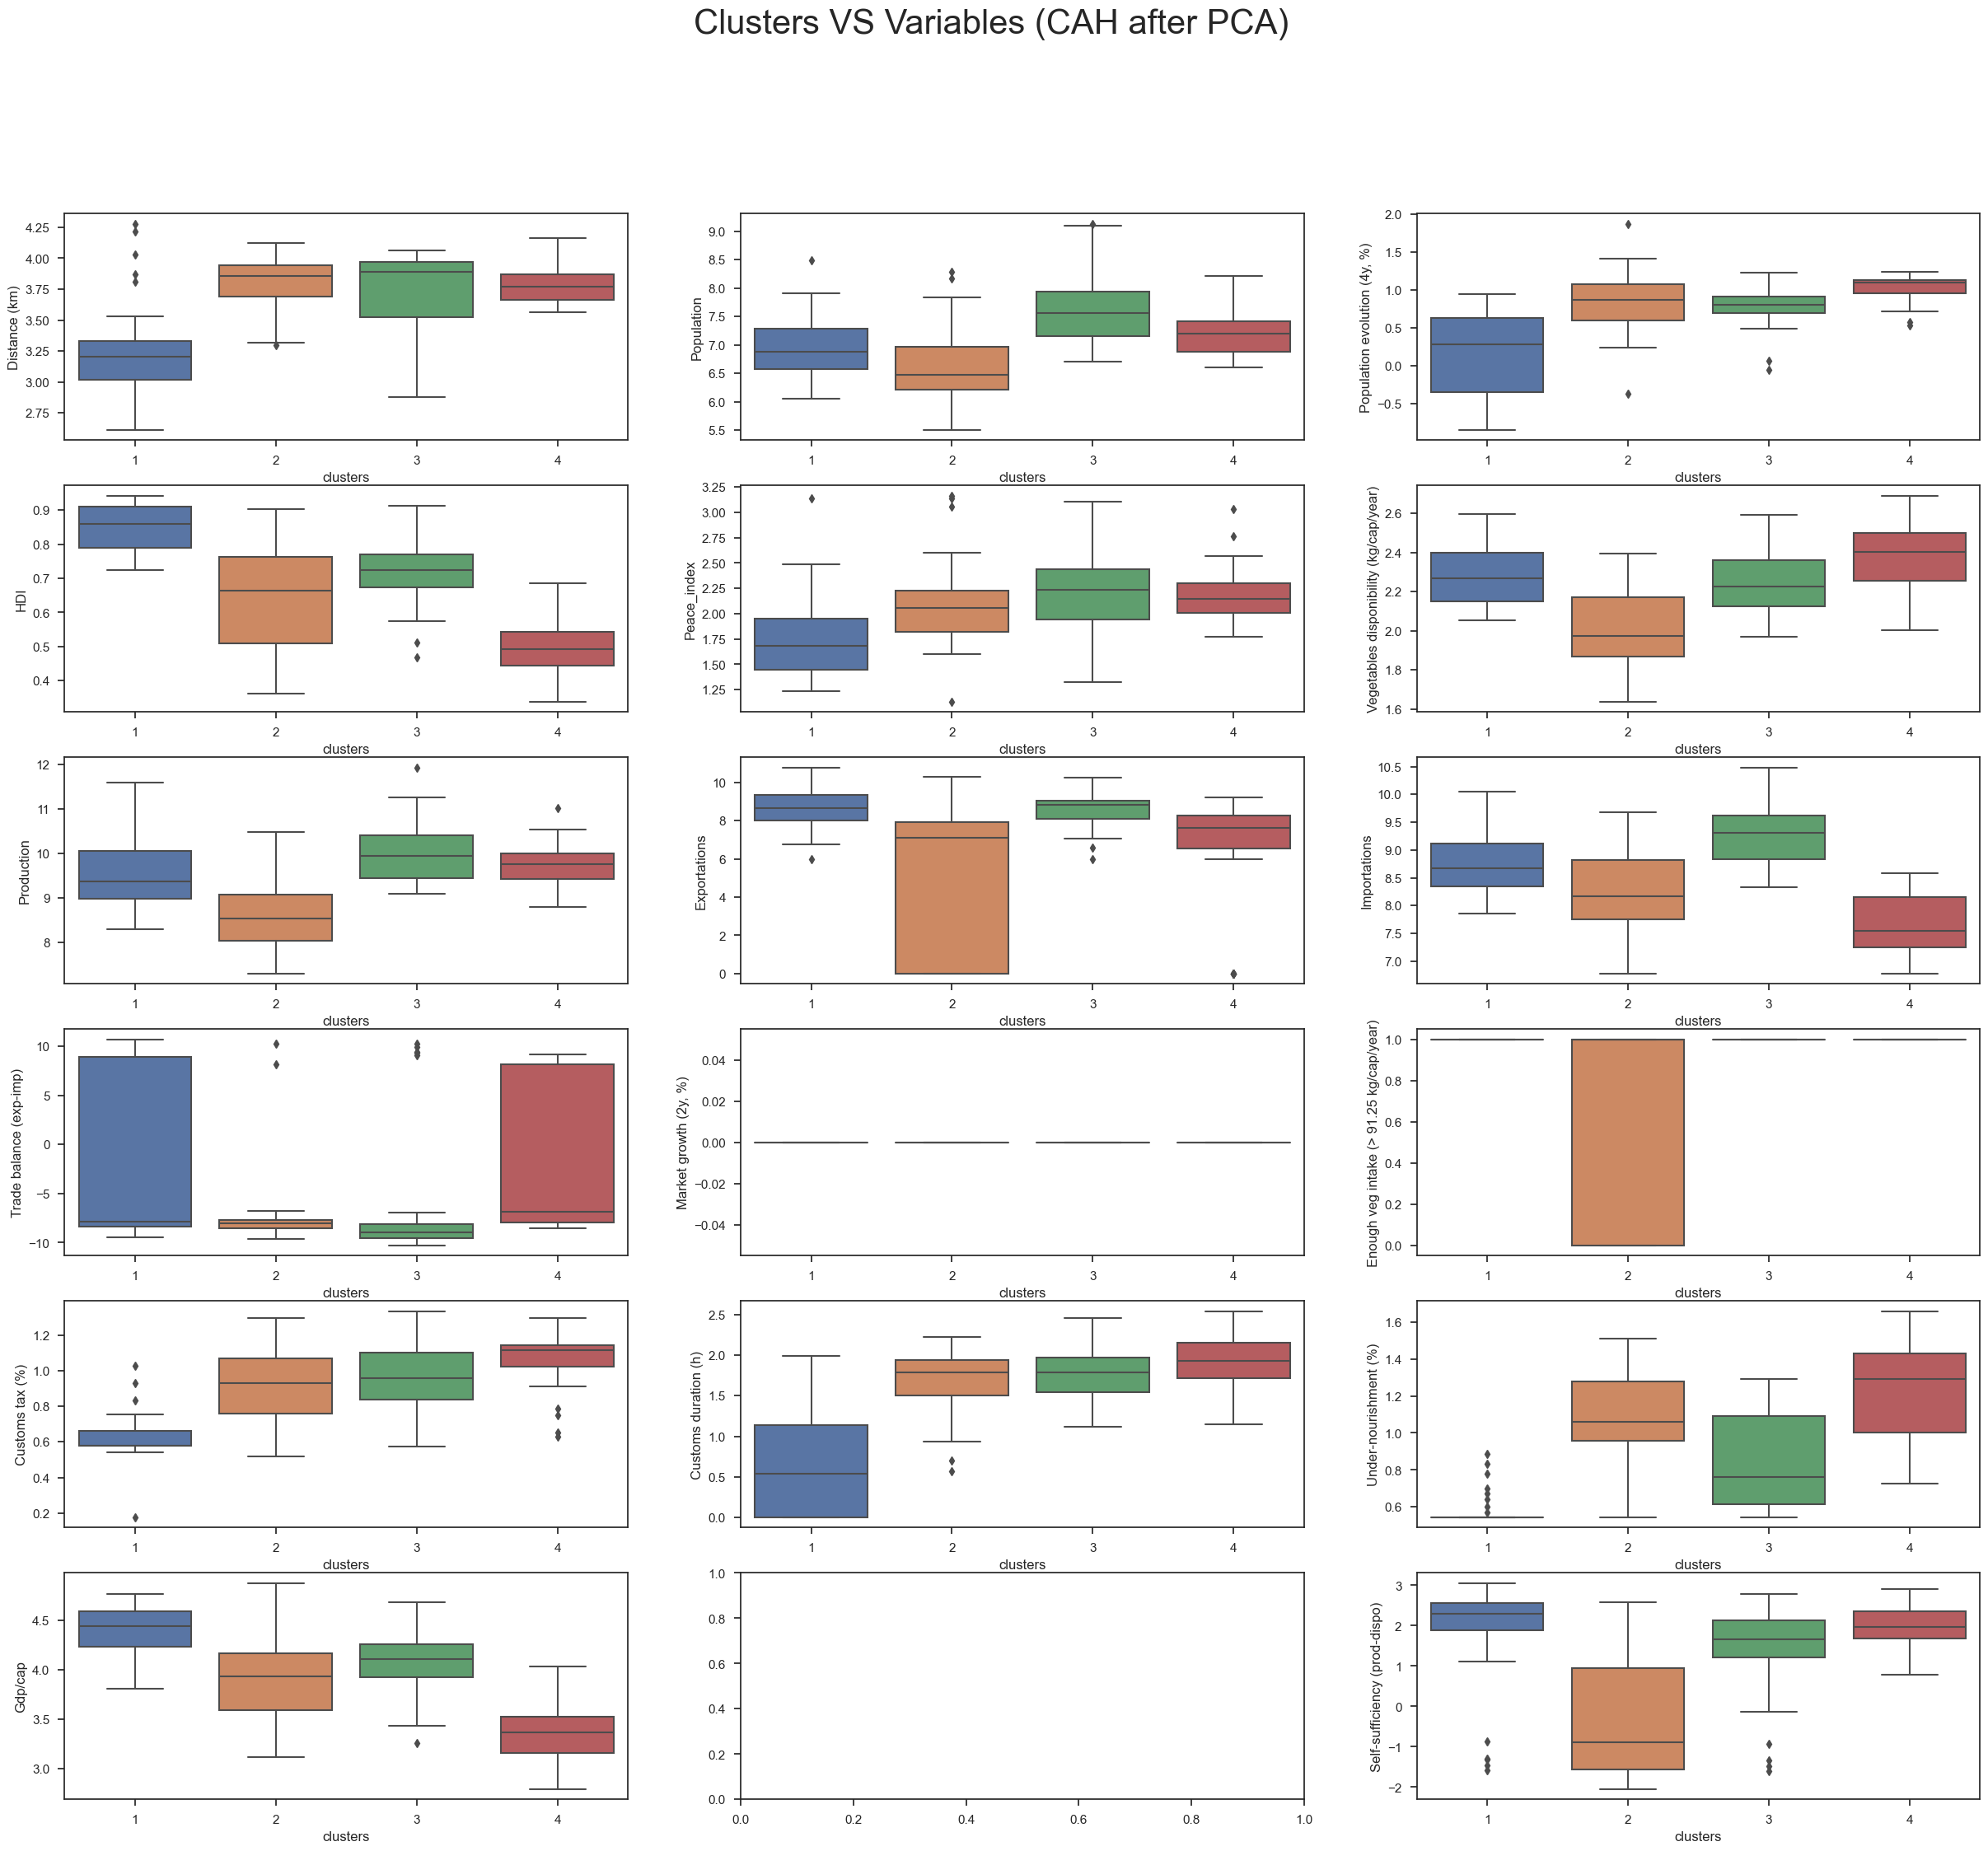

In [12]:
plt.rcParams['axes.grid'] = False
fig, axes = plt.subplots(6, 3, figsize=(30, 25))

sns.set(font_scale=0.8)
data = p9_cah_pca
x ='clusters'

fig.suptitle('Clusters VS Variables (CAH after PCA)', size=30)
sns.boxplot(ax=axes[0, 0], data=p9_cah_pca, x='clusters', y="Distance (km)")
sns.boxplot(ax=axes[0, 1], data=p9_cah_pca, x='clusters', y="Population")
sns.boxplot(ax=axes[0, 2], data=p9_cah_pca, x='clusters', y='Population evolution (4y, %)')
sns.boxplot(ax=axes[1, 0], data=p9_cah_pca, x='clusters', y='HDI')
sns.boxplot(ax=axes[1, 1], data=p9_cah_pca, x='clusters', y='Peace_index')
sns.boxplot(ax=axes[1, 2], data=p9_cah_pca, x='clusters', y='Vegetables disponibility (kg/cap/year)')
sns.boxplot(ax=axes[2, 0], data=p9_cah_pca, x='clusters', y='Production')
sns.boxplot(ax=axes[2, 1], data=p9_cah_pca, x='clusters', y='Exportations')
sns.boxplot(ax=axes[2, 2], data=p9_cah_pca, x='clusters', y='Importations')
sns.boxplot(ax=axes[3, 0], data=p9_cah_pca, x='clusters', y='Trade balance (exp-imp)')
sns.boxplot(ax=axes[3, 1], data=p9_cah_pca, x='clusters', y='Market growth (2y, %)')
sns.boxplot(ax=axes[3, 2], data=p9_cah_pca, x='clusters', y='Enough veg intake (> 91.25 kg/cap/year)')
sns.boxplot(ax=axes[4, 0], data=p9_cah_pca, x='clusters', y='Customs tax (%)')
sns.boxplot(ax=axes[4, 1], data=p9_cah_pca, x='clusters', y='Customs duration (h)')
sns.boxplot(ax=axes[4, 2], data=p9_cah_pca, x='clusters', y='Under-nourishment (%)')
sns.boxplot(ax=axes[5, 0], data=p9_cah_pca, x='clusters', y='Gdp/cap')
sns.boxplot(ax=axes[5, 2], data=p9_cah_pca, x='clusters', y='Self-sufficiency (prod-dispo)');

## Heatmaps

In [13]:
p9_cah_pca = p9_cah_pca.groupby(by='clusters').mean()

In [14]:
# les données sont centrées et réduites pour mettre à la même échelle les variables au sein des clusters
scaler = preprocessing.StandardScaler()

cah_sc = scaler.fit_transform(p9_cah_pca)
cah_sc = pd.DataFrame(cah_sc, index=p9_cah_pca.index, columns=p9_cah_pca.columns).T

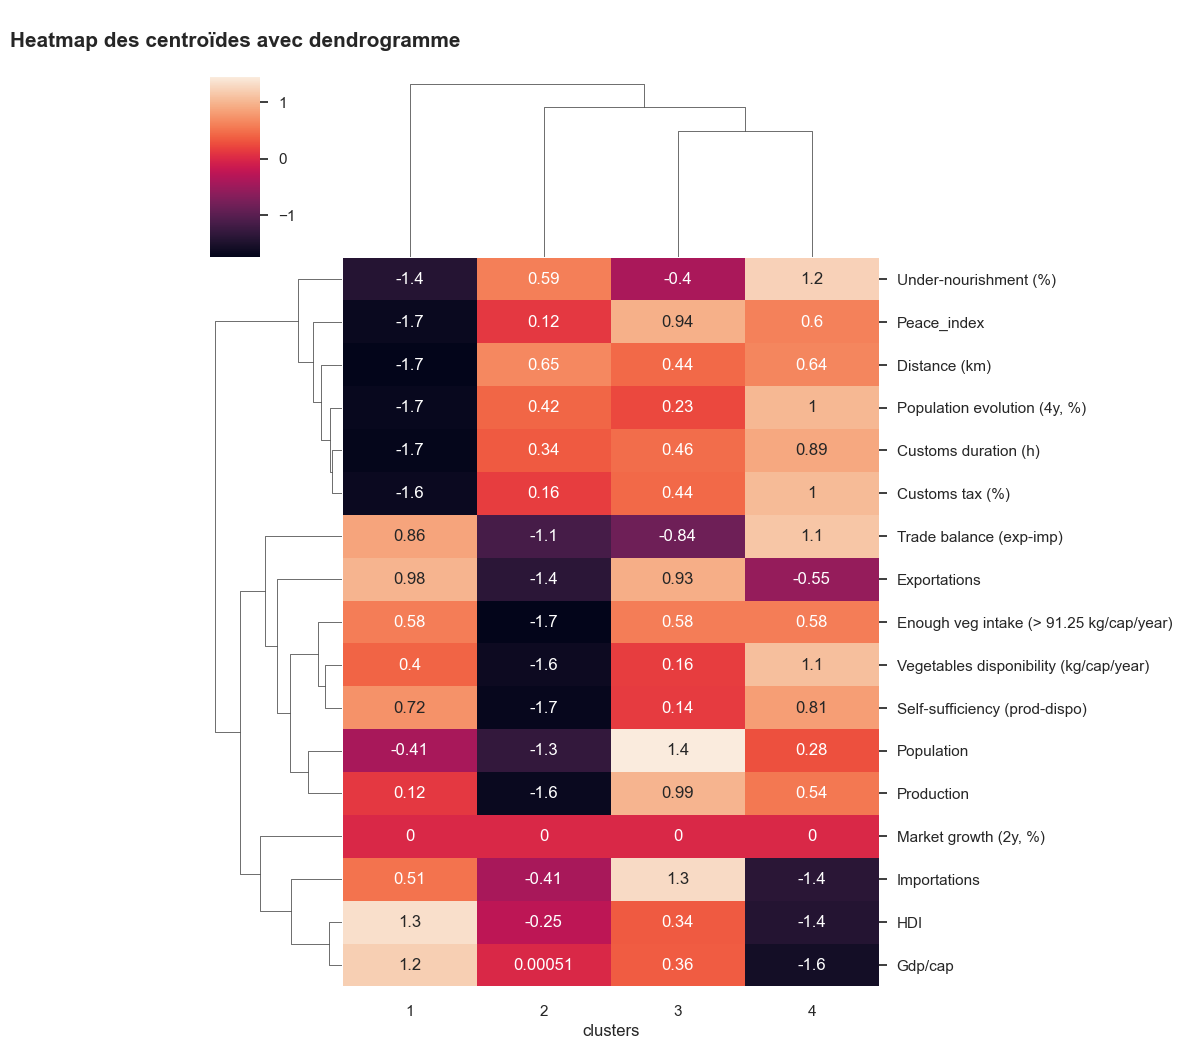

In [15]:
#fig = plt.figure(figsize=(15,12))
sns.set(font_scale=1)
sns.clustermap(cah_sc, annot=True)
plt.title('\nHeatmap des centroïdes avec dendrogramme\n', fontsize=15, fontweight='bold');

## Radar chart

In [16]:
#p9_cah_pca.columns

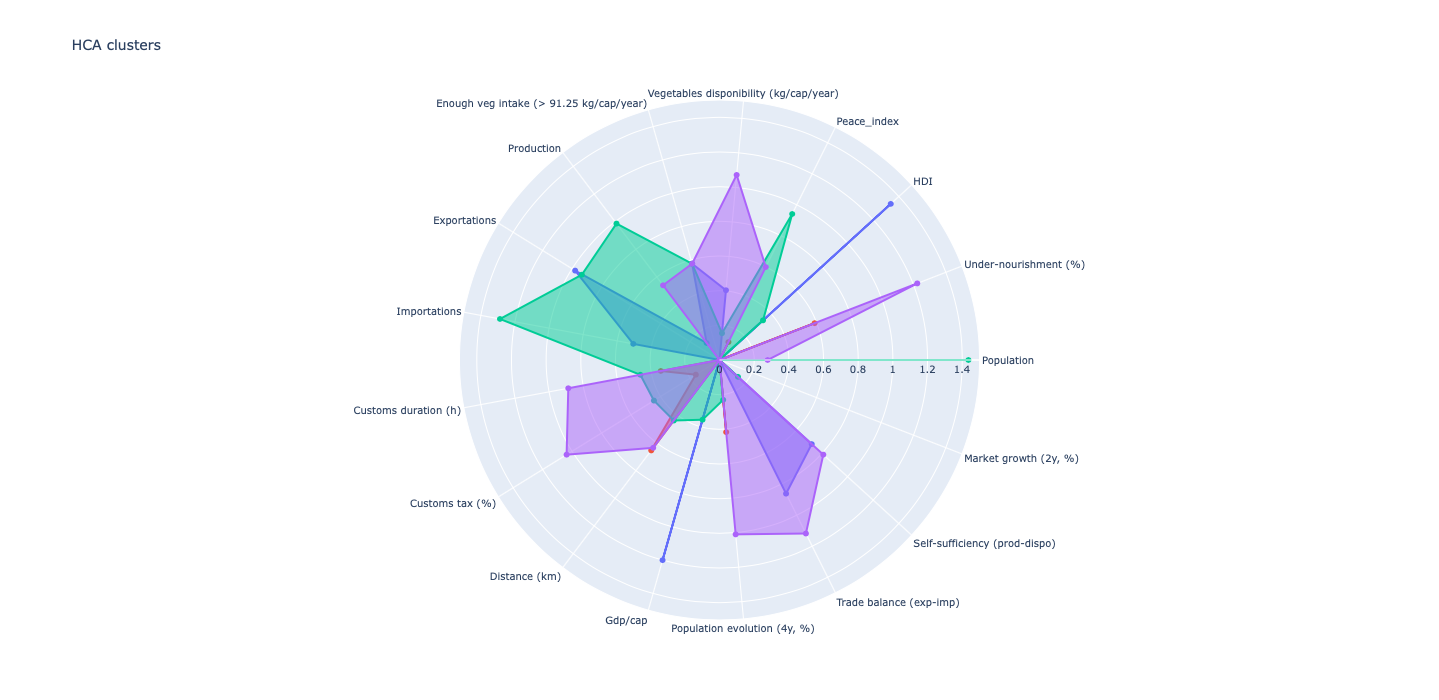

In [17]:
import plotly.graph_objects as go

categories = ['Population', 'Under-nourishment (%)', 'HDI', 'Peace_index',
       'Vegetables disponibility (kg/cap/year)',
       'Enough veg intake (> 91.25 kg/cap/year)', 'Production', 'Exportations',
       'Importations', 'Customs duration (h)', 'Customs tax (%)',
       'Distance (km)', 'Gdp/cap', 'Population evolution (4y, %)',
       'Trade balance (exp-imp)', 'Self-sufficiency (prod-dispo)', 'Market growth (2y, %)']

#fig = plt.figure(figsize=(20,20))
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cah_sc[1],
      theta=categories,
      fill='toself',
      name='C1'
))

fig.add_trace(go.Scatterpolar(
      r=cah_sc[2],
      theta=categories,
      fill='toself',
      name='C2'
))

fig.add_trace(go.Scatterpolar(
      r=cah_sc[3],
      theta=categories,
      fill='toself',
      name='C3'
))

fig.add_trace(go.Scatterpolar(
      r=cah_sc[4],
      theta=categories,
      fill='toself',
      name='C4'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1.5]
    )),
  showlegend=False
)

fig.update_layout(title_text="HCA clusters", font_size=10, width=800, height=700)
fig.show()